# Curve Fitting as a Machine Learning Problem 
Homework #1 is due on Sunday 1/29 by midnight. You may collaborate with other students, discuss the problems and work through solutions together. However, you must write up your solutions on your own and be able to explain them. Sharing code or copying code from classmates or external sources is not allowed. 

## Developing the Code

### Training and Test datasets (10 points)
Recall that the objective is to build a model that generalizes well on future data. In many applications, we do not have future data, so a common practice to evaluate our models is to split the overall dataset $\mathcal{D}$ into two disjoing sets $\mathcal{D}_\mbox{trn}$ and $\mathcal{D}_\mbox{tst}$, the training set and a hold-out test set, respectively. 

The idea is to train several models on the training set and evaluate them on the test set (which is why we hold it out, and treat it like *future* data). 

Define function `data_split(D, perc)` that randomly splits a given dataset $\mathcal{D}$ into a $\mathcal{D}_\mbox{trn}$, containing `perc` of the data and $\mathcal{D}_\mbox{tst}$, containing `1-perc` of the data. Assume $\mathcal{D}$ is a Python list `[x, y]` where `x`and `y` are 1-D Numpy arrays of the same size.

## Nonlinear Regression
This problem extends ordinary least squares regression, which uses a linear hypothesis class, to non-linear hypothesis classes. It also serves as a refresher for Python, which we will use for the programming assignments.

The (unknown) function we want to fit is $y_\mbox{true} = f_\mbox{true}(x) = \sin(x) + \sin(2x)$. This is a univariate function as it has only one input variable. 
The thin black line in the diagram below shows the unknown function $y_\mbox{true} = f_\mbox{true}(x)$. The red circles constitute the (noisy) input data. 

The objective in nonlinear regression is to create a model that best approximates $f_\mbox{true}$.

![image-2.png](attachment:image-2.png)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(114514)

In [14]:
# YOUR CODE HERE
print("haha")
def data_split(D, perc):
  n = D[0].shape[0] # this defines the number of samples
  # we get the permutation of the indicees of the observations
  ind = np.random.permutation(n) 
  pivot = int (np.round(n * perc))
  Dx_train = D[0][ind[0:pivot]]
  Dy_train = D[1][ind[0:pivot]]
  Dtrain = [Dx_train, Dy_train]
  Dx_test = D[0][ind[pivot:]]
  Dy_test = D[1][ind[pivot:]]
  Dtest = [Dx_test, Dy_test]
  return (Dtrain, Dtest)
# data_split(D, perc)

haha


### Monomial Basis Functions (10 points)
In order to learn nonlinear models using linear regression, we have to explicitly transform the data into a higher-dimensional space. The nonlinear hypothesis class we will consider is the set of $d$-degree polynomials of the form:

$$
f(x) = \begin{bmatrix} 1, x, x^2, \ldots, x^d\end{bmatrix}
\begin{bmatrix}
w_0 \\ w_1 \\ w_2 \\ \vdots \\ w_d
\end{bmatrix}
$$

The monomials $\{1, x, x^2,\ldots, x^d\}$ are called **basis functions**, and each basis function $x^j$ has a corresponding weight $w_j$ associated with it, for all $j = 1, \ldots, d$. When this transformation is applied to each data point, it produces the Vandermonde matrix:
$$
\mathbf{V} = \begin{bmatrix}
1 & x_1 & x_1^2 & \cdots & x_1^d\\
1 & x_2 & x_2^2 & \cdots & x_2^d\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & x_n & x_n^2 & \cdots & x_n^d
\end{bmatrix}
$$

Define function `transform_data(x, d)` that transforms the univariate input data given in vector form, $\mathbf{x}=[x_1, x_2, \ldots, x_n]$, into (high-dimensional) multivariate data $\mathbf{V}$ under the transformation $\phi(x_i) \rightarrow [1, x_i, x_i^2, \ldots, x_i^d]$, for each $x_i$. The function should return the corresponding Vandermonde matrix $\mathbf{V}$ of size $n \times (d+1)$.

*test code*
```
x = np.array([1,2,3,4,5,6])
y = x*x
D = [x, y]
Dtrain, Dtest = data_split(D, 0.75)
print(Dtrain)
print(Dtest)
```
*sample output* 
```
[array([3, 4, 1, 2]), array([ 9, 16,  1,  4])]
[array([6, 5]), array([36, 25])]
```
**Note:** Your output might not look exactly as above since `data_split()` selects data randomly. But the size of the different arrays should match.

In [15]:
# YOUR CODE HERE
x = np.array([1,2,3,4,5,6])
y = x*x
D = [np.array(x), np.array(y)]
Dtrain, Dtest = data_split(D, 0.75)
print(Dtrain)
print(Dtest)

# Define the transform_data() function
def transform_data(x, d):
  y = []
  for k in range(len(x)):
    y.append([1])
  # print(y)
  for i in range(d):
    for j in range(len(x)):
      y[j].append(pow(x[j],i+1))
  return np.asarray(y)

# test the transform_data() function
Dtrain = [np.array([1, 2, 5, 3]), np.array([1,  4,  25,  9])]
V = transform_data(Dtrain[0], 4)
print()
print(V)


[array([4, 1, 6, 5]), array([16,  1, 36, 25])]
[array([3, 2]), array([9, 4])]

[[  1   1   1   1   1]
 [  1   2   4   8  16]
 [  1   5  25 125 625]
 [  1   3   9  27  81]]


*Test code*
```
Dtrain = [np.array([1, 2, 5, 3]), np.array([1,  4,  25,  9])]
V = transform_data(Dtrain[0], 4)
print(V)
```
*output*
```
[[  1   1   1   1   1]
 [  1   2   4   8  16]
 [  1   5  25 125 625]
 [  1   3   9  27  81]]
``` 

### How to Train a Polynomial Model (15 points)
Linear regression problems are often solved via the ordinary least squares method. In this method, one seeks to minimize the objective function:
$$
J(\mathbf{w}) = \| \mathbf{y} - \mathbf{V}\mathbf{w}\|_2^2,
$$
where $\mathbf{V}$ is the Vandermonde matrix, and $\mathbf{y}=[y_1, y_2, \ldots, y_n]$. 

You might recall from a previous course that this is a convex quadratic optimization problem and has a unique solution. The solution can be obtain directly via the normal equations:
$$
(\mathbf{V}^T\mathbf{V})\mathbf{w} = \mathbf{V}^T\mathbf{y}.
$$

Define function `train_model(V, y)` that takes a Vandermonde matrix as input and returns the  weight vector $\mathbf{w}$ using ordinary least squares and the normal equations. 
Hint: Matrix-vector products using Numpy arrays are computed via the `@` operator or the `matmul()` function, not `*`. You might need to compute the Moore–Penrose inverse of $\mathbf{V}^T\mathbf{V}$.

In [16]:
# YOUR CODE HERE
def train_model(V, y):
  # w = (V'V)^-1V'y
  # compute (V'V)
  gram_V = np.matmul(V.T, V)
  
  # compute (V'V)^-1V'
  dot_V_pinv = np.linalg.pinv(gram_V) # Moore–Penrose inverse, so pinv()
  dot_inv = np.matmul(dot_V_pinv, V.T)
  # print(dot_inv)
  
  # compute (V'V)^-1V'y
  w = np.matmul(dot_inv, y)

  return w



# test the train_model() function
V = np.array([[  1,   3,   9,  27,  81],
 [  1,   4,  16,  64, 256],
 [  1,   1,   1,   1,   1],
 [  1,   2,   4,   8,  16]])
Dtrain = [np.array([3, 4, 1, 2]), np.array([ 9, 16,  1,  4])]
w = train_model(V, Dtrain[1])
print(w)


[-0.19082235  0.39754657  0.7217174   0.07950931 -0.00795093]


*Test code*
```
V = np.array([[  1,   3,   9,  27,  81],
 [  1,   4,  16,  64, 256],
 [  1,   1,   1,   1,   1],
 [  1,   2,   4,   8,  16]])
Dtrain = [np.array([3, 4, 1, 2]), np.array([ 9, 16,  1,  4])]
w = train_model(V, Dtrain[1])
print(w)
```
*output*
```
[-0.19082235  0.39754657  0.7217174   0.07950931 -0.00795093]
```

### How to Test a Model (10 points)
Define function `test_model(x, y, w)` that takes test data $\mathbf{x}_\mbox{tst}$ and $\mathbf{y}_\mbox{tst}$ and a polynomial model's weight vector $\mathbf{w}$ as input and evaluates performance of the model by calculating the mean square error $e_\mbox{MSE} = \frac{1}{m}\| \mathbf{y}_\mbox{tst} - \mathbf{V}_\mbox{tst} \mathbf{w}\|_2^2$. 

Note that $m$ is the number of examples in the test data and that $\mathbf{V}_\mbox{tst}$ is constructed from $\mathbf{x}_\mbox{tst}$ and $d+1$, the dimension of $\mathbf{w}$.

In [17]:
# YOUR CODE HERE
def test_model(x, y, w):
  Vtst = transform_data(x, len(w)-1)
  # print(Vtst)
  residual = y - (Vtst @ w)
  squared_resid = np.matmul(residual.T, residual)
  MSE = np.sum(squared_resid) / len(x)
  # MSE = np.sum(np.power(y - (Vtst @ w), 2)) / len(x). --> this also works
  return MSE

# test of the test_model() function
Dtest = [np.array([6, 5]), np.array([36, 25])]
w = np.array([-0.19082235,  0.39754657,  0.7217174,   0.07950931, -0.00795093])
mse = test_model(Dtest[0], Dtest[1], w)
print('mse = ', mse)
# output should be 0.4733702748858607

mse =  0.47337027488586747


*Test code*
```
Dtest = [np.array([6, 5]), np.array([36, 25])]
w = np.array([-0.19082235,  0.39754657,  0.7217174,   0.07950931, -0.00795093])
mse = test_model(Dtest[0], Dtest[1], w)
print('mse = ', mse)
```
*output*
```
mse =  0.4865029675581952
```

### Putting Everything Together (15 points)
Define function `nonlinear_regression(Dtrain, Dtest, d)` that receives 
* Dtrain : [x, y] where x and y are the training data and labels, respectively
* Dtest : [x, y] where x and y are the test data and labels, respectively
* d : the degree of the polynomial approximation to $f(x)$

Use the functions you previously defined to train and test a model of degree $d$.
Return the MSE, the model's weight vector, and the vector of predictions

In [18]:
# YOUR CODE HERE
def nonlinear_regression(Dtrain, Dtest, d):
  V = transform_data(Dtrain[0], d)
  # print("V: ", V)
  w = train_model(V, Dtrain[1])
  # print("w: ", w)
  mse = test_model(Dtest[0], Dtest[1], w)

  Vtst = transform_data(Dtest[0], d)
  yhat = (Vtst @ w)

  return (mse, w, yhat)

Dtrain = [np.array([3, 4, 1, 2]), np.array([-0.13829549, 0.23255575, 1.75076841, 0.15249493])]
Dtest = [np.array([6, 5]), np.array([-0.81598842, -1.50294539])]
mse, w, yhat = nonlinear_regression(Dtrain, Dtest, 4)
print('Model weights: ', w)
print('Mean square error: ', mse)
# MSE should be: 50.12783861483532

Model weights:  [ 3.06159054 -0.07525771 -1.96821512  0.82601635 -0.09336566]
Mean square error:  50.12783861285275


*Test code*
```
Dtrain = [np.array([3, 4, 1, 2]), np.array([-0.13829549, 0.23255575, 1.75076841, 0.15249493])]
Dtest = [np.array([6, 5]), np.array([-0.81598842, -1.50294539])]
mse, w, yhat = nonlinear_regression(Dtrain, Dtest, 4)
print('Model weights: ', w)
print('Mean square error: ', mse)
```
*output*
```
Model weights:  [ 3.06159054 -0.07525771 -1.96821512  0.82601635 -0.09336566]
Mean square error:  5.006387850278648
```

## Experimentation

Now that your code is complete and tested, let's generate a "larger" synthetic dataset to explore nonlinear regression as a machine learning problem.

### Generating synthetic data 
Generate synthetic input (data) $x_i$ by sampling $n = 200$ points from a uniform distribution on the interval $[0, 6]$. 

In [19]:
import random
random.seed(114514)

n = 200

In [20]:
x = np.random.uniform(0, 6, n)

Generate the corresponding noisy outputs (labels) as $y_i = f_\mbox{true}(x_i) + \eta_i$, where $\eta_i$ represents the ever-present noise added to a signal during data acquisition. We  assumed noise to be independent from the signal and resulting from a normal (Gaussian) distribution of the form $N(0, 0.25)$. The synthetic data set is $\mathcal{D} = \{(x_i, y_i)\}_{i=1}^n$.

In [21]:
random.seed(114514)

x = np.random.uniform(0, 6, n)
y = np.sin(x) + np.sin(2*x) + np.random.normal(0, 0.25, n)

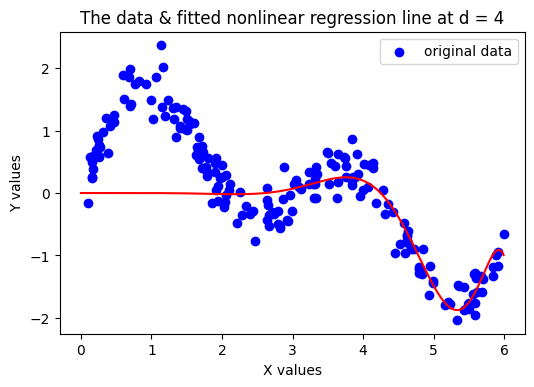

In [26]:
# YOUR CODE HERE
# compute the synthetic dataset D
D_n = np.array([x, y])
# print(D)

fig, ax = plt.subplots()
fig.set_dpi(100.0)

x_values = D_n[0]
y_values = D_n[1]

# create the scatterplot
ax.scatter(x_values, y_values, c="blue", marker="o", label="original data")

x_good = np.arange(0,6,0.01)

V = transform_data(x_good,w.size-1) # in this case, d = 4, so w.size - 1 = 4
y_good = V @ w


plt.plot(x_good, y_good, color = "red")

# ax.plot(x_values, y_fit, c="blue", label="fitted line")

ax.set_xlabel("X values")
ax.set_ylabel("Y values")
ax.set_title("The data & fitted nonlinear regression line at d = 4")
ax.legend()


# compute the mean square error to see how the performance improves



### Ploting the Data (10 points)
Plot the dataset $\mathcal{D}$ as red points in a 2-D graph using Matplotlib.

For reference, also plot a thin line showing what the true outputs ${y_\mbox{true}}_i= f_\mbox{true}(x_i)$ would be.

Some useful options for `plt.pyplot()` that you might need include `marker='o', markerfacecolor='r', linestyle='none'`, `linestyle='-'`, and `label="data"`.

Your plot should look very similar to the one at top of this assignment.


### Experiments (20 points)
Use your `nonlinear_regression()` function to learn and evaluate models for $d = 5,...,15$ using the training and test sets created above. 

Create a table showing how the test error $e_\mbox{MSE}$ changes with the degree of the polynomial $d$. 

**(Bonus: 5 points)** Plot the data as we did before and show on it the learned nonlinear regression models for $d = 5,...,16$.

    Degress (d)  Test Error (MSE)
0             5             0.113
1             6             0.173
2             7             0.072
3             8             0.080
4             9             0.197
5            10             0.130
6            11             0.843
7            12             0.659
8            13             0.675
9            14             0.662
10           15             0.637
11           16             0.615



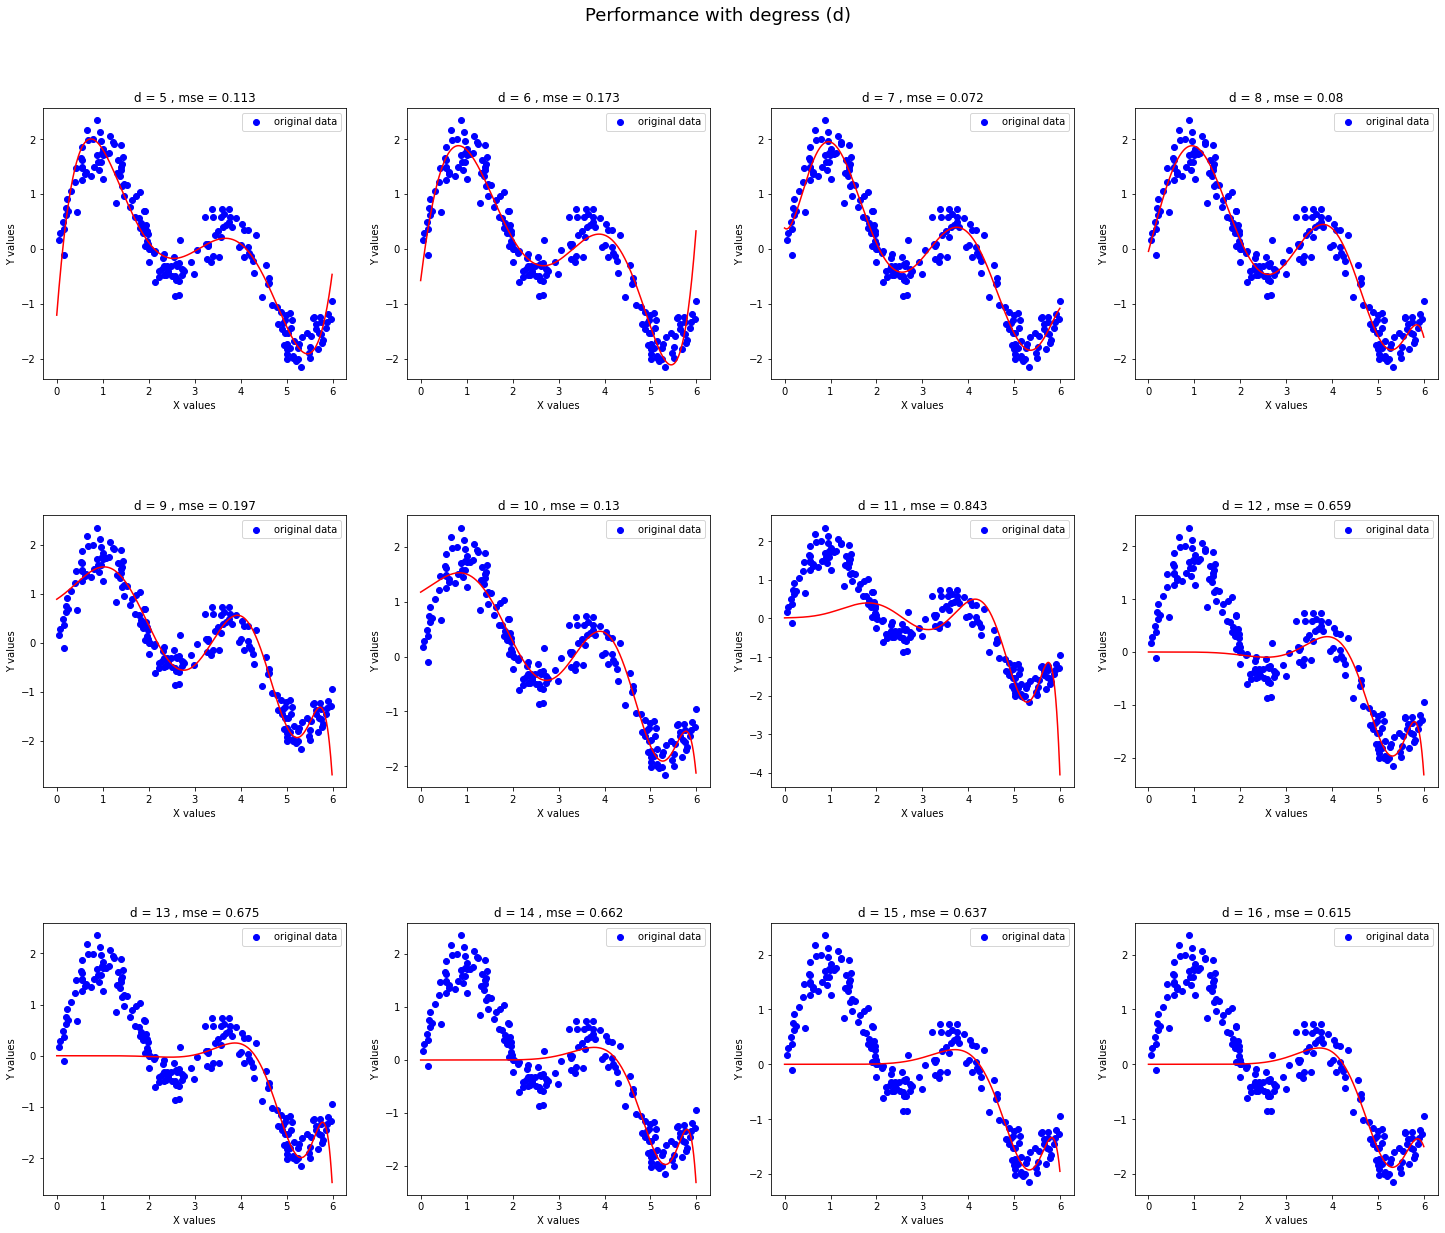

In [23]:
# YOUR CODE HERE

%matplotlib inline

# create the list of d
d = list(range(5,17,1))
# print(d)

# Create the x and y values with seed
# set the seed for x and y
random.seed(114514)
x = np.random.uniform(0, 6, n)
y = np.sin(x) + np.sin(2*x) + np.random.normal(0, 0.25, n)

D = [np.array(x), np.array(y)]

# split the data
Dtrain, Dtest = data_split(D,0.75)
Dtrain = np.array(Dtrain)
Dtest = np.array(Dtest)

test_result = []
weight_list = []

# for every degree (d), compute the performance of the model by measuring the metric (mse)
for i in d:
  mse, w, yhat = nonlinear_regression(Dtrain, Dtest, i)
  # print(mse)
  test_result.append(mse)
  weight_list.append(w)

# print(test_result)

# Create a table showing how the test error  eMSE  changes with the degree of the polynomial d.
import pandas as pd

result = pd.DataFrame({"Degress (d)": d, "Test Error (MSE)": np.round(np.array(test_result),3)})
print(result)
print()

# print(weight_list[2])


# (Bonus: 5 points) Plot the data as we did before and show on it the learned nonlinear regression models for  d=5,...,16 .

# define the plot grid that we will work on
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(25, 20))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Performance with degress (d)", fontsize=18, y=0.95)


# loop through the subplots and plot data
for i, ax in zip(range(12), axs.ravel()):
    
    x_values = D[0]
    y_values = D[1]

    # create the scatterplot
    ax.scatter(x_values, y_values, c="blue", marker="o", label="original data")

    x_good = np.arange(0,6,0.01)

    V = transform_data(x_good,d[i])
    y_good = V @ weight_list[i]


    ax.plot(x_good, y_good, color = "red")

    # ax.plot(x_values, y_fit, c="blue", label="fitted line")

    ax.set_xlabel("X values")
    ax.set_ylabel("Y values")
    graph_name = "d = " + str(d[i]) + " , mse = " + str(round(test_result[i],3))
    ax.set_title(graph_name)
    ax.legend()

plt.show()





### Analysis (10 points)
Which model is the best, according to the test data? 

What can you say about the bias-variance tradeoff in this nonlinear regression example?



Best Model: According to the previous experiment result, the test error was at its minimum when the tuning parameter (d) has a value of 7 (corresponding value of MSE = 0.074). Therefore, the best model was derived when we apply the transformation of x data with a degree of 7. The corresponding weight of the model is: [ 2.25884087e-01  1.21389520e-01  8.60458488e+00 -1.21056903e+01
  6.39597648e+00 -1.60887041e+00  1.93968413e-01 -9.02112191e-03]

Bias-Variance tradeoff: In this case, the bias, or the error of measurement of real life data, is relatively high with small value of tuning parameter d. For instance, at the extreme case, where d = 1, the curve is just a straight line, which has very small variance as now the curve was really insensitive to the changing pattern of the data, but it is very biased as the test error is really large (as it predicts nothing!). However, when we increase the d to a very high value, say 11, the curve becomes very sensitive to the change in values (as now every value was so large), that the curve overfits the data, and thus we observed a gradual increase in the test error as the curve now fits the training data too much that it missed the overall pattern of the data (that's why it fit poorly on the testing data)

The d = 7 is the sweet point that balanced the bias-variance and make the prediction relatively accurate

I have make a graph below that demonstrate the changing of the test accuracy with degree from 1 to 13.



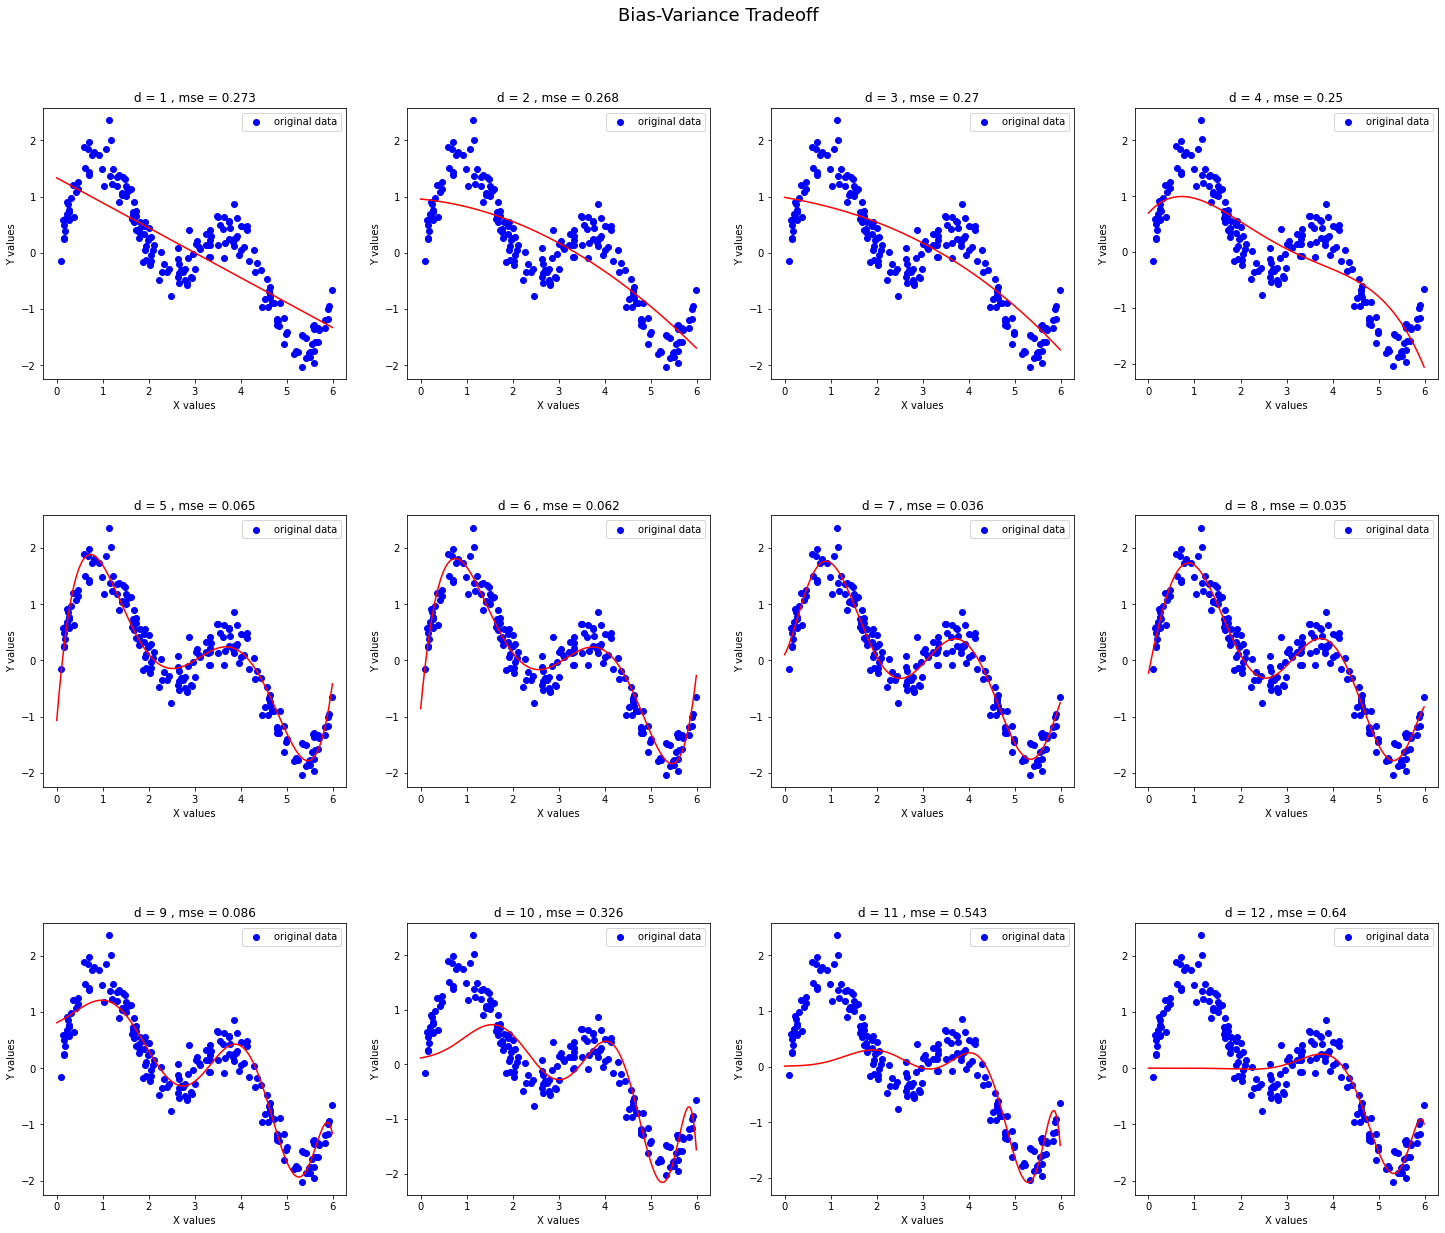

In [24]:
# d with range 1-13

%matplotlib inline

# create the list of d
d = list(range(1,13,1))

# Create the x and y values
random.seed(114514)
x = np.random.uniform(0, 6, n)
y = np.sin(x) + np.sin(2*x) + np.random.normal(0, 0.25, n)

D = [np.array(x), np.array(y)]

# split the data
Dtrain, Dtest = data_split(D,0.75)
Dtrain = np.array(Dtrain)
Dtest = np.array(Dtest)

test_result = []
weight_list = []

# for every degree (d), compute the performance of the model by measuring the metric (mse)
for i in d:
  mse, w, yhat = nonlinear_regression(Dtrain, Dtest, i)
  # print(mse)
  test_result.append(mse)
  weight_list.append(w)


# define the plot grid that we will work on
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(25, 20))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Bias-Variance Tradeoff", fontsize=18, y=0.95)


# loop through the subplots and plot data
for i, ax in zip(range(12), axs.ravel()):
    
    x_values = D[0]
    y_values = D[1]

    # create the scatterplot
    ax.scatter(x_values, y_values, c="blue", marker="o", label="original data")

    x_good = np.arange(0,6,0.01)

    V = transform_data(x_good,d[i])
    y_good = V @ weight_list[i]


    ax.plot(x_good, y_good, color = "red")

    # ax.plot(x_values, y_fit, c="blue", label="fitted line")

    ax.set_xlabel("X values")
    ax.set_ylabel("Y values")
    graph_name = "d = " + str(d[i]) + " , mse = " + str(round(test_result[i],3))
    ax.set_title(graph_name)
    ax.legend()

plt.show()